In [1]:
from util import *
from eval import *
from data import FacesDataset, data_transform
import time
# from ..utils.data import FacesDataset, data_transform
from torch.utils.data import DataLoader, Dataset, random_split
import numpy as np
import matplotlib.pyplot as plt

/home/abhigyan/.local/lib/python3.8/site-packages/skimage/io/manage_plugins.py:23: UserWarning: Your installed pillow version is < 7.1.0. Several security issues (CVE-2020-11538, CVE-2020-10379, CVE-2020-10994, CVE-2020-10177) have been fixed in pillow 7.1.0 or higher. We recommend to upgrade this library.
  from .collection import imread_collection_wrapper


In [44]:
class RequestDetails(object):
	"""docstring for RequestDetails"""
	def __init__(self, accuracy, latency, tasks, input_image):
		self.accuracy = accuracy
		self.latency = int(latency)
		self.tasks = tasks
		self.input_image = input_image
		

def process_request(request_details):
	model_to_use = None
	# print(three_task_table)
	task_count = len(request_details.tasks)
	if(task_count > 1):
		for latency in three_task_table["age"]:
			if(latency <= request_details.latency):
				if(model_to_use == None):
					model_to_use = three_task_table["age"][latency]
				else:	
					mean_acc = (float(three_task_table["age"][latency].accuracy[0]) + float(three_task_table["gender"][latency].accuracy[1]) + float(three_task_table["ethnicity"][latency].accuracy[2])) / 3.0
					mean_acc_existing = (float(model_to_use.accuracy[0]) + float(model_to_use.accuracy[1]) + float(model_to_use.accuracy[2]))/3.0 
					if(mean_acc_existing < mean_acc): model_to_use = three_task_table["age"][latency] 
	else:
		if(request_details.tasks[0] == "age"):
			for latency in age_task_table["age"]:
				if(latency <= request_details.latency):
					if(model_to_use == None):
						model_to_use = age_task_table["age"][latency]
					else:
						if(model_to_use.accuracy[0] < float(age_task_table["age"][latency].accuracy[0])):
							model_to_use = age_task_table["age"][latency]
		elif(request_details.tasks[0] == "gender"):
			for latency in gender_task_table["gender"]:
				if(latency <= request_details.latency):
					if(model_to_use == None):
						model_to_use = gender_task_table["gender"][latency]	
					else:
						if(model_to_use.accuracy[0] < float(gender_task_table["gender"][latency].accuracy[0])):
							model_to_use = gender_task_table["gender"][latency]
		elif(request_details.tasks[0] == "ethnicity"):	
			for latency in ethnicity_task_table["ethnicity"]:
				if(latency <= request_details.latency):
					if(model_to_use == None):
						model_to_use = ethnicity_task_table["ethnicity"][latency]	
					else:
						if(model_to_use.accuracy[0] < float(ethnicity_task_table["ethnicity"][latency].accuracy[0])):
							model_to_use = ethnicity_task_table["ethnicity"][latency]

	if(model_to_use == None):
		## Cannot meet latency requirement with any model
		return None, None
	else:
		model = torch.load(model_to_use.file_path, map_location=torch.device('cpu'))
		model.cpu()
		output = model(request_details.input_image)
		# return output, model_to_use.latency
		if(task_count > 1):
			return output, (float(model_to_use.accuracy[0]) + float(model_to_use.accuracy[1]) + float(model_to_use.accuracy[2]))/3.0
		else:
			return output, model_to_use.accuracy[0]

def process_request_with_accuracy(request_details):
	model_to_use = None
	task_count = len(request_details.tasks)
	if(task_count > 1):
		for latency in three_task_table["age"]:
			# print(float(three_task_table["gender"][latency].accuracy[1]), request_details.accuracy[1])
			mean_acc = float(three_task_table["age"][latency].accuracy[0]) >= request_details.accuracy[0] and\
				float(three_task_table["gender"][latency].accuracy[1]) >= request_details.accuracy[1] and\
				float(three_task_table["ethnicity"][latency].accuracy[2]) >= request_details.accuracy[2]
			if(latency <= request_details.latency and mean_acc == True):
					model_to_use = three_task_table["age"][latency]
	else:
		if(request_details.tasks[0] == "age"):
			for latency in age_task_table["age"]:
				if(latency <= request_details.latency and float(age_task_table["age"][latency].accuracy[0]) >= request_details.accuracy):
					if(model_to_use == None):
						model_to_use = age_task_table["age"][latency]	
					else:
						if(float(model_to_use.accuracy[0]) < float(age_task_table["age"][latency].accuracy[0])):
							model_to_use = age_task_table["age"][latency]
		elif(request_details.tasks[0] == "gender"):
			for latency in gender_task_table["gender"]:
				if(latency <= request_details.latency and float(gender_task_table["gender"][latency].accuracy[0]) >= request_details.accuracy):
					if(model_to_use == None):
						model_to_use = gender_task_table["gender"][latency]	
					else:
						if(float(model_to_use.accuracy[0]) < float(gender_task_table["gender"][latency].accuracy[0])):
							model_to_use = gender_task_table["gender"][latency]
		elif(request_details.tasks[0] == "ethnicity"):	
			for latency in ethnicity_task_table["ethnicity"]:
				if(latency <= request_details.latency and float(ethnicity_task_table["ethnicity"][latency].accuracy[0]) >= request_details.accuracy):
					if(model_to_use == None):
						model_to_use = ethnicity_task_table["ethnicity"][latency]	
					else:
						if(float(model_to_use.accuracy[0]) < float(ethnicity_task_table["ethnicity"][latency].accuracy[0])):
							model_to_use = ethnicity_task_table["ethnicity"][latency]

	if(model_to_use == None):
		## Cannot meet latency/accuracy requirement with any model
		return None, None
	else:
		# print("asd", request_details.tasks)
		# print(model_to_use.latency, end=" ")
		model = torch.load(model_to_use.file_path, map_location=torch.device('cpu'))
		model.cpu()
		output = model(request_details.input_image)
		return model_to_use.latency, model_to_use.accuracy[0]
		# return output, model_to_use.latency

def process_request_only_mtl(request_details, with_accuracy=False):
	if(request_details.tasks[0] == "age"):
		model_to_use = None
		for latency in three_task_table["age"]:
			if(latency <= request_details.latency):
				if(with_accuracy):
					if( float(three_task_table["age"][latency].accuracy[0]) < request_details.accuracy): continue
				if(model_to_use == None):
					model_to_use = three_task_table["age"][latency]
				else:
					if(float(model_to_use.accuracy[0]) < float(three_task_table["age"][latency].accuracy[0])):
						model_to_use = three_task_table["age"][latency]
		if(model_to_use == None):
			return None, None
		else:
			model = torch.load(model_to_use.file_path, map_location=torch.device('cpu'))
			model.cpu()
			output = model(request_details.input_image)
			return model_to_use.latency, model_to_use.accuracy[0]
	elif(request_details.tasks[0] == "gender"):
		model_to_use = None
		for latency in three_task_table["gender"]:
			if(latency <= request_details.latency):
				if(with_accuracy):
					if( float(three_task_table["gender"][latency].accuracy[1]) < request_details.accuracy): continue
				if(model_to_use == None):
					model_to_use = three_task_table["gender"][latency]	
				else:
					if(float(model_to_use.accuracy[1]) < float(three_task_table["gender"][latency].accuracy[1])):
						model_to_use = three_task_table["gender"][latency]
		if(model_to_use == None):
			return None, None
		else:
			model = torch.load(model_to_use.file_path, map_location=torch.device('cpu'))
			model.cpu()
			output = model(request_details.input_image)
			return model_to_use.latency, model_to_use.accuracy[1]

	elif(request_details.tasks[0] == "ethnicity"):	
		model_to_use = None
		for latency in three_task_table["ethnicity"]:
			if(latency <= request_details.latency):
				if(with_accuracy):
					if( float(three_task_table["ethnicity"][latency].accuracy[2]) < request_details.accuracy): continue
				if(model_to_use == None):
					model_to_use = three_task_table["ethnicity"][latency]	
				else:
					if(float(model_to_use.accuracy[2]) < float(three_task_table["ethnicity"][latency].accuracy[2])):
						model_to_use = three_task_table["ethnicity"][latency]
		if(model_to_use == None):
			return None, None
		else:
			model = torch.load(model_to_use.file_path, map_location=torch.device('cpu'))
			model.cpu()
			output = model(request_details.input_image)
			return model_to_use.latency, model_to_use.accuracy[2]


def process_request_single_model_system(request_details, with_accuracy=False):
	# print(three_task_table)
	task_count = len(request_details.tasks)
	if( len(request_details.tasks) > 1): req_latency = request_details.latency/3.0
	else: req_latency = request_details.latency 
	perf = []
	output = None
	if(len(request_details.tasks) > 1 or request_details.tasks[0] == "age"):
		model_to_use = None
		for latency in single_age_task_table["age"]:
			if(latency <= req_latency):
				if(with_accuracy):
					if(len(request_details.tasks) > 1): acc = request_details.accuracy[0]
					else: acc = request_details.accuracy
					if( float(single_age_task_table["age"][latency].accuracy[0]) < acc): continue
				if(model_to_use == None):
					model_to_use = single_age_task_table["age"][latency]
				else:
					if(model_to_use.accuracy[0] < float(single_age_task_table["age"][latency].accuracy[0])):
						model_to_use = single_age_task_table["age"][latency]
		if(model_to_use == None):
			return None, None
		else:
			model = torch.load(model_to_use.file_path, map_location=torch.device('cpu'))
			model.cpu()
			output = model(request_details.input_image)
			perf.append(model_to_use.accuracy[0])
	if(len(request_details.tasks) > 1 or request_details.tasks[0] == "gender"):
		model_to_use = None
		for latency in single_gender_task_table["gender"]:
			if(latency <= req_latency):
				if(with_accuracy):
					if(len(request_details.tasks) > 1): acc = request_details.accuracy[1]
					else: acc = request_details.accuracy
					if( float(single_gender_task_table["gender"][latency].accuracy[0]) < acc): continue
				if(model_to_use == None):
					model_to_use = single_gender_task_table["gender"][latency]	
				else:
					if(model_to_use.accuracy[0] < float(single_gender_task_table["gender"][latency].accuracy[0])):
						model_to_use = single_gender_task_table["gender"][latency]
		if(model_to_use == None):
			return None, None
		else:
			model = torch.load(model_to_use.file_path, map_location=torch.device('cpu'))
			model.cpu()
			output = model(request_details.input_image)
			perf.append(model_to_use.accuracy[0])
	if(len(request_details.tasks) > 1 or request_details.tasks[0] == "ethnicity"):	
		model_to_use = None
		for latency in single_ethnicity_task_table["ethnicity"]:
			if(latency <= req_latency):
				if(with_accuracy):
					if(len(request_details.tasks) > 1): acc = request_details.accuracy[2]
					else: acc = request_details.accuracy
					if( float(single_ethnicity_task_table["ethnicity"][latency].accuracy[0]) < acc): continue
				if(model_to_use == None):
					model_to_use = single_ethnicity_task_table["ethnicity"][latency]	
				else:
					if(model_to_use.accuracy[0] < float(single_ethnicity_task_table["ethnicity"][latency].accuracy[0])):
						model_to_use = single_ethnicity_task_table["ethnicity"][latency]
		if(model_to_use == None):
			return None, None
		else:
			model = torch.load(model_to_use.file_path, map_location=torch.device('cpu'))
			model.cpu()
			output = model(request_details.input_image)
			perf.append(model_to_use.accuracy[0])

	return model_to_use.latency, np.mean(perf)

def process_batch_requests(requests, min_accuracy=False, mtl_model=True, only_mtl=False):

	## Can write some queing stuff
	## iterate on the requests and call process_request
	latency_hit = []
	accuracy_hit = []
	lat_acc_pair = []
	for request in requests:
		if(min_accuracy):
			start_time = time.time()
			if(only_mtl):
				output, accuracy = process_request_only_mtl(request, with_accuracy=True)
			elif(mtl_model):
				output, accuracy = process_request_with_accuracy(request)
			else:                
				output, accuracy = process_request_single_model_system(request, with_accuracy=True)
			end_time = time.time()
			inf_time = (end_time-start_time)*1000
			# print(inf_time, request.latency, accuracy)
			# print(inf_time, start_time, end_time)
			# print(inf_time)
			if(inf_time <= request.latency + 5 and output!=None):
			# if(output!=None and output <=request.latency):
				latency_hit.append(1)
			else:
				latency_hit.append(0)

			if(accuracy!=None ):
				accuracy_hit.append(1)
			else:
				accuracy_hit.append(0)
			
		else:
			start_time = time.time()
			if(only_mtl):
				output, accuracy = process_request_only_mtl(request)
			elif(mtl_model):
				output, accuracy = process_request(request)
			else:
				output, accuracy = process_request_single_model_system(request)
			end_time = time.time()
			inf_time = (end_time-start_time)*1000
			# print(inf_time, request.latency, accuracy)
			# print(inf_time, end_time, output)
			if(inf_time <= request.latency and output!=None):
				latency_hit.append(1)
			else:
				latency_hit.append(0)
			if (accuracy != None):
				lat_acc_pair.append([request.latency, accuracy])
	return latency_hit, accuracy_hit, lat_acc_pair


In [3]:
def plot_double_pareto_curve_graph(pair1, pair2):
	fig, ax = plt.subplots(1, figsize=(8, 6))
	fig.suptitle('All three tasks', fontsize=15)

	x1, y1 = [], []
	x2, y2 = [], []
	for i in pair1:
		x1.append(i[0])
		y1.append(float(i[1]))
	for i in pair2:
		x2.append(i[0])
		y2.append(float(i[1]))

	ax.plot(x1, y1, color="red", label="MTL Model")
	ax.plot(x2, y2, color="green", label="Single Task Models")
	plt.xlabel("Latency")
	plt.ylabel("Performance Scores")
	plt.legend(loc="lower right", frameon=False)

	plt.show()
    

In [4]:
def plot_triple_pareto_curve_graph(pair1, pair2, pair3, title):
	fig, ax = plt.subplots(1, figsize=(8, 6))
	fig.suptitle(title, fontsize=15)

	x1, y1 = [], []
	x2, y2 = [], []
	x3, y3 = [], []
	for i in pair1:
		x1.append(i[0])
		y1.append(float(i[1]))
	for i in pair2:
		x2.append(i[0])
		y2.append(float(i[1]))
	for i in pair3:
		x3.append(i[0])
		y3.append(float(i[1]))

	ax.plot(x1, y1, color="red", label="MTL Model with Prune Single Task Heads")
	ax.plot(x2, y2, color="green", label="Single Task Models")
	ax.plot(x3, y3, color="blue", label="Traditional MTL Model")
	plt.xlabel("Latency")
	plt.ylabel("Performance Scores")
	plt.legend(loc="lower right", frameon=False)

	plt.show()
    

In [16]:
def plot_mishits(mtl, single, trad_mtl):
    
    barWidth = 0.25
    fig = plt.subplots(figsize =(12, 8))
    
    br1 = np.arange(len(mtl))
    br2 = [x + barWidth for x in br1]
    br3 = [x + barWidth for x in br2]
    
    plt.bar(br1, mtl, color ='r', width = barWidth,
        edgecolor ='grey', label ='MTL with pruned task head')
    plt.bar(br2, single, color ='g', width = barWidth,
            edgecolor ='grey', label ='Single Task Model System')
    plt.bar(br3, trad_mtl, color ='b', width = barWidth,
            edgecolor ='grey', label ='Traditional standalone MTL System')
    
    plt.xlabel('Tasks', fontweight ='bold', fontsize = 15)
    plt.ylabel('Mishits', fontweight ='bold', fontsize = 15)
    plt.xticks([r + barWidth for r in range(len(mtl))],
            ['All Tasks', 'Age', 'Gender', 'Ethnicity'])

    plt.legend()
    plt.show()

In [6]:
### Load in the data
folder = '../UTKFace'
transform = data_transform()
dataset = FacesDataset(folder=folder, transform=transform)

train_len = int(len(dataset)*0.8)
val_len = len(dataset) - train_len

train_dataset, val_dataset = random_split(dataset, [train_len, val_len], torch.Generator().manual_seed(8))


dataloader = DataLoader(dataset=train_dataset, batch_size=16, shuffle=True)


In [7]:
print("Loading all task models..")
### All three tasks
three_task_models = load_all_task_models_info(dataloader, "model_score_lookup_multitask.tsv", "../models/model_variants")
three_task_table = get_models_table(three_task_models)

print("Loading single age models..")
### Age
single_age_task_models = load_one_task_models_info(dataloader, "model_score_lookup_singletask.tsv", "../models/model_variants", "age", False)
single_age_task_table = get_models_table(single_age_task_models)
print("Loading single gender models..")
### Gender
single_gender_task_models = load_one_task_models_info(dataloader, "model_score_lookup_singletask.tsv", "../models/model_variants", "gender", False)
single_gender_task_table = get_models_table(single_gender_task_models)

print("Loading single ethnicity models..")
### Ethnicity
single_ethnicity_task_models = load_one_task_models_info(dataloader, "model_score_lookup_singletask.tsv", "../models/model_variants/", "ethnicity", False)
single_ethnicity_task_table = get_models_table(single_ethnicity_task_models)

min_latency = int(min(three_task_table["age"]))
max_latency = int(max(three_task_table["age"])) + 10



Loading all task models..
Loading single age models..
Loading single gender models..
Loading single ethnicity models..


In [8]:

print("Loading age models..")
### Age
age_task_models = load_one_task_models_info(dataloader, "model_score_lookup_multitask.tsv", "../models/model_variants", "age", True)
age_task_table = get_models_table(age_task_models)
print("Loading gender models..")
### Gender
gender_task_models = load_one_task_models_info(dataloader, "model_score_lookup_multitask.tsv", "../models/model_variants", "gender", True)
gender_task_table = get_models_table(gender_task_models)

print("Loading ethnicity models..")
### Ethnicity
ethnicity_task_models = load_one_task_models_info(dataloader, "model_score_lookup_multitask.tsv", "../models/model_variants/", "ethnicity", True)
ethnicity_task_table = get_models_table(ethnicity_task_models)

Loading age models..
Loading gender models..
Loading ethnicity models..


In [ ]:
## All Tasks 

batch_size = 8 # No relevance now since we are not doing queueing
requests = []
tasks = ["age", "gender", "ethnicity"]
hits = []
lat_acc = []
for i in range(min_latency, max_latency):
	if(len(requests) == batch_size):	
		lat_hit, acc_hit, lat_acc_pair = process_batch_requests(requests)
		requests = []
		hits+=lat_hit
		lat_acc+=lat_acc_pair
	request = RequestDetails(0, i, tasks, next(iter(dataloader))[0])
	requests.append(request)

lat_hit, acc_hit, lat_acc_pair = process_batch_requests(requests)
hits+=lat_hit
lat_acc+=lat_acc_pair

# SLO_hit = calculate_SLO_hit(hits)

# print("All Task MTL System (No Accuracy) SLO hit/mishit ratio: " + str(SLO_hit) + ", hits: " + str(sum(hits)) + ", mishits: " + str(len(hits) - sum(hits)))
# print()


batch_size = 8 # No relevance now since we are not doing queueing
requests = []
tasks = ["age", "gender", "ethnicity"]
hits = []
lat_acc1 = []
for i in range(min_latency, max_latency):
	if(len(requests) == batch_size):	
		lat_hit, acc_hit, lat_acc_pair = process_batch_requests(requests, False, False)
		requests = []
		hits+=lat_hit
		lat_acc1+=lat_acc_pair
	request = RequestDetails(0, i, tasks, next(iter(dataloader))[0])
	requests.append(request)

lat_hit, acc_hit, lat_acc_pair = process_batch_requests(requests)
hits+=lat_hit
lat_acc1+=lat_acc_pair



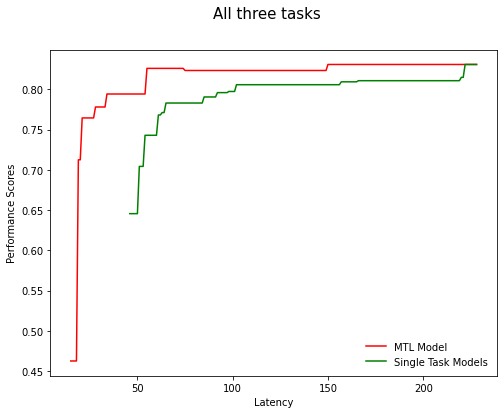

In [35]:
plot_double_pareto_curve_graph(lat_acc, lat_acc1)

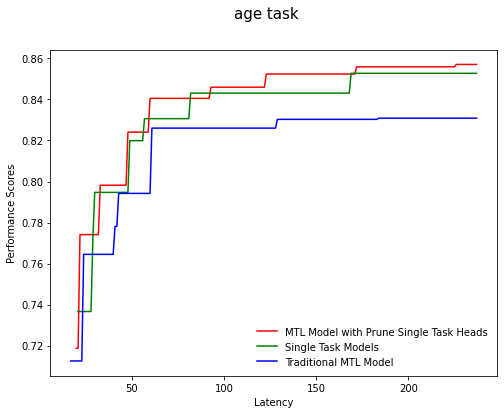

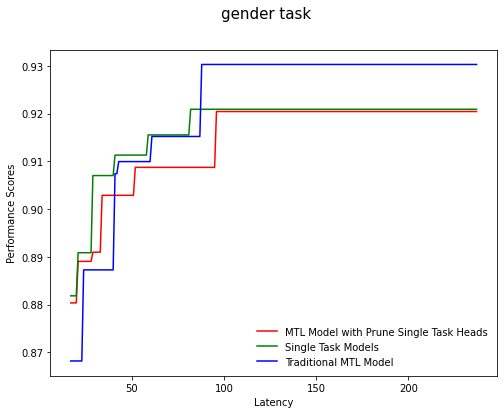

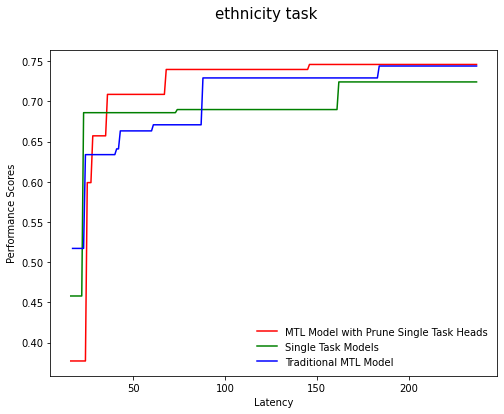

In [45]:
## Age Task

tasks_list = [["age"], ["gender"],["ethnicity"]]

for tasks in tasks_list:
    batch_size = 8 # No relevance now since we are not doing queueing
    # tasks = ["age"]
    requests = []
    hits = []
    lat_acc_age = []
    for i in range(min_latency, max_latency):
        if(len(requests) == batch_size):	
            lat_hit, acc_hit, lat_acc_pair = process_batch_requests(requests)
            requests = []
            hits+=lat_hit
            lat_acc_age+=lat_acc_pair
        request = RequestDetails(0, i, tasks, next(iter(dataloader))[0])
        requests.append(request)

    lat_hit, acc_hit, lat_acc_pair = process_batch_requests(requests)
    hits+=lat_hit
    lat_acc_age+=lat_acc_pair

    # SLO_hit = calculate_SLO_hit(hits)

    # print("All Task MTL System (No Accuracy) SLO hit/mishit ratio: " + str(SLO_hit) + ", hits: " + str(sum(hits)) + ", mishits: " + str(len(hits) - sum(hits)))
    # print()


    batch_size = 8 # No relevance now since we are not doing queueing
    requests = []
    # tasks = ["age"]
    hits = []
    lat_acc_age1 = []
    for i in range(min_latency, max_latency):
        if(len(requests) == batch_size):	
            lat_hit, acc_hit, lat_acc_pair = process_batch_requests(requests, mtl_model=False)
            requests = []
            hits+=lat_hit
            lat_acc_age1+=lat_acc_pair
        request = RequestDetails(0, i, tasks, next(iter(dataloader))[0])
        requests.append(request)

    lat_hit, acc_hit, lat_acc_pair = process_batch_requests(requests, mtl_model=False)
    hits+=lat_hit
    lat_acc_age1+=lat_acc_pair

    batch_size = 8 # No relevance now since we are not doing queueing
    requests = []
    # tasks = ["age"]
    hits = []
    lat_acc_age2 = []
    for i in range(min_latency, max_latency):
        if(len(requests) == batch_size):	
            lat_hit, acc_hit, lat_acc_pair = process_batch_requests(requests, only_mtl=True)
            requests = []
            hits+=lat_hit
            lat_acc_age2+=lat_acc_pair
        request = RequestDetails(0, i, tasks, next(iter(dataloader))[0])
        requests.append(request)

    lat_hit, acc_hit, lat_acc_pair = process_batch_requests(requests, only_mtl=True)
    hits+=lat_hit
    lat_acc_age2+=lat_acc_pair
    plot_triple_pareto_curve_graph(lat_acc_age, lat_acc_age1, lat_acc_age2, tasks[0] + " task")

In [33]:
#Mis-hit calculations with Accuracy cutoff 
mtl, single, trad_mtl = [], [], []

batch_size = 8 # No relevance now since we are not doing queueing
requests = []
tasks = ["age", "gender", "ethnicity"]
hits = []
acc_hits = []
accuracy = [0.75, 0.90, 0.60] 

for i in range(min_latency, max_latency):
	if(len(requests) == batch_size):	
		lat_hit, acc_hit, lat_acc_pair= process_batch_requests(requests, min_accuracy=True)
		requests = []
		hits+=lat_hit
		acc_hits+=acc_hit

	request = RequestDetails(accuracy, i, tasks, next(iter(dataloader))[0])
	requests.append(request)

lat_hit, acc_hit, lat_acc_pair = process_batch_requests(requests, min_accuracy=True)
hits+=lat_hit
acc_hits+=acc_hit

actual_hits = []
for i in range(len(hits)):
    if(hits[i] == 1 and acc_hits[i] ==1):
        actual_hits.append(1)
    else:
        actual_hits.append(0)
        

print("All Task MTL System (Accuracy>75%) SLO mishit rate: " + str((len(actual_hits) - sum(actual_hits))/ len(actual_hits)) + ", hits: " + str(sum(actual_hits)) + ", mishits: " + str(len(actual_hits) - sum(actual_hits)))

mtl.append((len(actual_hits) - sum(actual_hits))/ len(actual_hits))

batch_size = 8 # No relevance now since we are not doing queueing
requests = []
tasks = ["age", "gender", "ethnicity"]
hits = []
acc_hits = []
accuracy = [0.75, 0.90, 0.60]
for i in range(min_latency, max_latency):
	if(len(requests) == batch_size):	
		lat_hit, acc_hit, lat_acc_pair = process_batch_requests(requests, min_accuracy=True, mtl_model=False)
		requests = []
		hits+=lat_hit
		acc_hits+=acc_hit
	request = RequestDetails(accuracy, i, tasks, next(iter(dataloader))[0])
	requests.append(request)

lat_hit, acc_hit, lat_acc_pair = process_batch_requests(requests, min_accuracy=True, mtl_model=False)
hits+=lat_hit
acc_hits+=acc_hit

actual_hits = []
for i in range(len(hits)):
    if(hits[i] == 1 and acc_hits[i] ==1):
        actual_hits.append(1)
    else:
        actual_hits.append(0)
        

print("All Task Single Model System (Accuracy>75%) SLO mishit rate: " + str((len(actual_hits) - sum(actual_hits))/ len(actual_hits)) + ", hits: " + str(sum(actual_hits)) + ", mishits: " + str(len(actual_hits) - sum(actual_hits)))

single.append((len(actual_hits) - sum(actual_hits))/ len(actual_hits))
trad_mtl.append(0)

All Task MTL System (Accuracy>75%) SLO mishit rate: 0.11711711711711711, hits: 196, mishits: 26
All Task Single Model System (Accuracy>75%) SLO mishit rate: 0.31981981981981983, hits: 151, mishits: 71


In [34]:
#Mis-hit calculations with Accuracy cutoff - 0.75

## Single Tasks 
tasks_list = [["age"], ["gender"],["ethnicity"]]
accuracy_list = [0.75, 0.90, 0.60] 
idx = -1
for tasks in tasks_list:
    idx+=1
    batch_size = 8 # No relevance now since we are not doing queueing
    requests = []
    hits = []
    acc_hits = []
    accuracy = accuracy_list[idx]
    for i in range(min_latency, max_latency):
        if(len(requests) == batch_size):	
            lat_hit, acc_hit, lat_acc_pair= process_batch_requests(requests, min_accuracy=True)
            requests = []
            hits+=lat_hit
            acc_hits+=acc_hit

        request = RequestDetails(accuracy, i, tasks, next(iter(dataloader))[0])
        requests.append(request)

    lat_hit, acc_hit, lat_acc_pair = process_batch_requests(requests, min_accuracy=True)
    hits+=lat_hit
    acc_hits+=acc_hit

    actual_hits = []
    for i in range(len(hits)):
        if(hits[i] == 1 and acc_hits[i] ==1):
            actual_hits.append(1)
        else:
            actual_hits.append(0)

    print(tasks[0] + " MTL System with Accuracy cutoff SLO mishit rate: " + str((len(actual_hits) - sum(actual_hits))/ len(actual_hits)) + ", hits: " + str(sum(actual_hits)) + ", mishits: " + str(len(actual_hits) - sum(actual_hits)))

    mtl.append((len(actual_hits) - sum(actual_hits))/ len(actual_hits))
    
    batch_size = 8 # No relevance now since we are not doing queueing
    requests = []
    hits = []
    acc_hits = []
    accuracy = accuracy_list[idx]
    
    for i in range(min_latency, max_latency):
        if(len(requests) == batch_size):	
            lat_hit, acc_hit, lat_acc_pair = process_batch_requests(requests, min_accuracy=True, mtl_model=False)
            requests = []
            hits+=lat_hit
            acc_hits+=acc_hit
        request = RequestDetails(accuracy, i, tasks, next(iter(dataloader))[0])
        requests.append(request)

    lat_hit, acc_hit, lat_acc_pair = process_batch_requests(requests, min_accuracy=True, mtl_model=False)
    hits+=lat_hit
    acc_hits+=acc_hit

    actual_hits = []
    for i in range(len(hits)):
        if(hits[i] == 1 and acc_hits[i] ==1):
            actual_hits.append(1)
        else:
            actual_hits.append(0)


    print(tasks[0] + " Single Model System with Accuracy Cutoff SLO mishit rate: " + str((len(actual_hits) - sum(actual_hits))/ len(actual_hits)) + ", hits: " + str(sum(actual_hits)) + ", mishits: " + str(len(actual_hits) - sum(actual_hits)))


    single.append((len(actual_hits) - sum(actual_hits))/ len(actual_hits))
    
    
    batch_size = 8 # No relevance now since we are not doing queueing
    requests = []
    hits = []
    acc_hits = []
    accuracy = accuracy_list[idx]
    for i in range(min_latency, max_latency):
        if(len(requests) == batch_size):	
            lat_hit, acc_hit, lat_acc_pair = process_batch_requests(requests, min_accuracy=True, only_mtl=True)
            requests = []
            hits+=lat_hit
            acc_hits+=acc_hit
        request = RequestDetails(accuracy, i, tasks, next(iter(dataloader))[0])
        requests.append(request)

    lat_hit, acc_hit, lat_acc_pair = process_batch_requests(requests, min_accuracy=True, only_mtl=True)
    hits+=lat_hit
    acc_hits+=acc_hit
    actual_hits = []
    for i in range(len(hits)):
        if(hits[i] == 1 and acc_hits[i] ==1):
            actual_hits.append(1)
        else:
            actual_hits.append(0)


    print(tasks[0] + " Traditional MTL System with Accuracy Cutoff SLO mishit rate: " + str((len(actual_hits) - sum(actual_hits))/ len(actual_hits)) + ", hits: " + str(sum(actual_hits)) + ", mishits: " + str(len(actual_hits) - sum(actual_hits)))

    trad_mtl.append((len(actual_hits) - sum(actual_hits))/ len(actual_hits))
    

age MTL System with Accuracy cutoff SLO mishit rate: 0.03153153153153153, hits: 215, mishits: 7
age Single Model System with Accuracy Cutoff SLO mishit rate: 0.06306306306306306, hits: 208, mishits: 14
age Traditional MTL System with Accuracy Cutoff SLO mishit rate: 0.036036036036036036, hits: 214, mishits: 8
gender MTL System with Accuracy cutoff SLO mishit rate: 0.08108108108108109, hits: 204, mishits: 18
gender Single Model System with Accuracy Cutoff SLO mishit rate: 0.06306306306306306, hits: 208, mishits: 14
gender Traditional MTL System with Accuracy Cutoff SLO mishit rate: 0.11261261261261261, hits: 197, mishits: 25
ethnicity MTL System with Accuracy cutoff SLO mishit rate: 0.05855855855855856, hits: 209, mishits: 13
ethnicity Single Model System with Accuracy Cutoff SLO mishit rate: 0.036036036036036036, hits: 214, mishits: 8
ethnicity Traditional MTL System with Accuracy Cutoff SLO mishit rate: 0.036036036036036036, hits: 214, mishits: 8


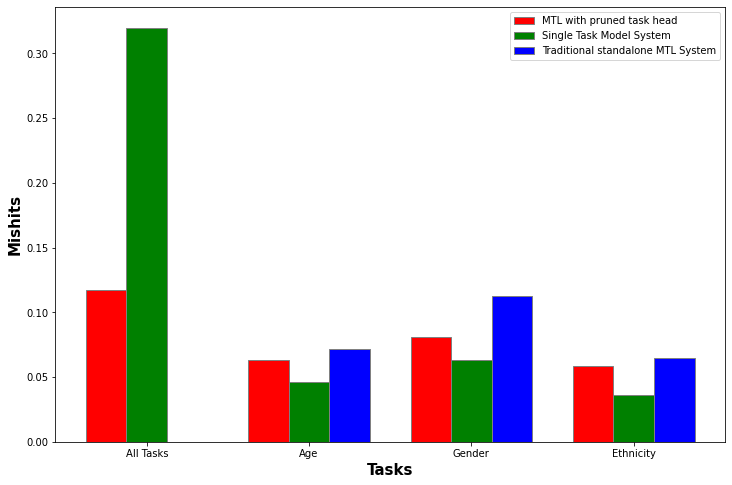

In [41]:
plot_mishits(mtl, single, trad_mtl)